In [1]:
import json
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import load_dataset, Dataset, load_from_disk
import matplotlib.pyplot as plt 
from transformers import AutoTokenizer

/home/yilong/miniconda3/envs/vllm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_parquet('../data/train/ToM_train_600.parquet')

In [3]:
len(df)

600

In [4]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct", trust_remote_code=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   story_structure     600 non-null    object
 1   infilled_story      600 non-null    object
 2   question            600 non-null    object
 3   answer              600 non-null    object
 4   question_type       600 non-null    object
 5   params              600 non-null    object
 6   nth_order           600 non-null    int64 
 7   is_interesting      600 non-null    bool  
 8   story_type          600 non-null    object
 9   story_structure_wn  600 non-null    object
dtypes: bool(1), int64(1), object(8)
memory usage: 42.9+ KB


In [6]:
df.groupby(['story_type']).params.count()

story_type
all                              45
all+asymmetric                   27
allbutfantom                     43
allbutfantom+asymmetric          58
tomi                             76
tomi+asymmetric                  30
tomi+info-exchange               45
tomi+info-exchange+asymmetric    61
tomi+object-state                62
tomi+object-state+asymmetric     52
tomi+room-changes                36
tomi+room-changes+asymmetric     60
tomi-object-state                 4
tomi-object-state+asymmetric      1
Name: params, dtype: int64

In [7]:
df.groupby(['is_interesting','nth_order']).story_structure.count()

is_interesting  nth_order
False            1            12
                 2            68
True            -1           181
                 1           133
                 2           206
Name: story_structure, dtype: int64

In [8]:
dfs = df.groupby(['story_structure']).answer.count().reset_index()

In [9]:
len(dfs)

177

In [10]:
len(df.groupby(['infilled_story']).answer.count().reset_index())

177

In [11]:
dfs.answer.max()

18

In [12]:
dft = df.copy()
dft.index = range(len(dft))

In [13]:
SYSTEM_PROMPT = """You are a helpful assistant. First, think through the question internally before providing the final answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> step by step reasoning here </think><answer> answer here </answer>"""

In [14]:
XML_COT_FORMAT = """Story: {}\n Question:{}"""

In [15]:
dft.columns

Index(['story_structure', 'infilled_story', 'question', 'answer',
       'question_type', 'params', 'nth_order', 'is_interesting', 'story_type',
       'story_structure_wn'],
      dtype='object')

In [16]:
dfm = dft.melt(id_vars=['question', 'answer'], value_vars=['infilled_story', 'story_structure', 'story_structure_wn'], var_name='story_group',value_name='story')

In [17]:
def get_prompts(dft):
    prompt = []
    for i in range(len(dft)):
        prompt.append( [
                {'role': 'system', 'content': SYSTEM_PROMPT},
                {'role': 'user', 'content': XML_COT_FORMAT.format(dft['story'][i], dft['question'][i])}
            ])
    return prompt

In [18]:
prompts = get_prompts(dfm)

In [31]:
print(prompts[2][0]['content'])

You are a helpful assistant. First, think through the question internally before providing the final answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> step by step reasoning here </think><answer> answer here </answer>


In [19]:
print(prompts[2][1]['content'])

Story: The consulate building stood quietly on a narrow street lined with trees, its stone facade reflecting the morning sun. Inside, the consulate meeting room and reception area were dimly lit, with soft hums of computers and air conditioning filling the air. Jasmine walked past the security desk, exchanging a brief greeting with the officer, as she made her way into the consulate's bustling reception area. The soft glow of the waiting area's lamps and the murmur of quiet conversations enveloped her, a familiar backdrop to her daily routine. Unnoticed by the other consulate staff and visitors, Addison witnessed the moment when Jasmine moved the silver letter opener to its new home on top of the metal file cabinet in the reception area. The consulate's reception area hummed along, its staff and visitors none the wiser to the subtle shift of the silver letter opener's position from the metal file cabinet to the leather briefcase that Jasmine had accomplished with practiced ease. The si

In [20]:
dfm['prompt'] = prompts

In [21]:
data = Dataset.from_pandas(dfm)

In [23]:
data['answer']

['cardboard box',
 'leather pouch',
 'consulate reception area',
 'waiting lounge',
 'canvas tote bag',
 'metal toolbox',
 'canvas tote bag',
 'metal toolbox',
 'leather wallet',
 'cardboard box',
 'wooden chest',
 'canvas duffel bag',
 'wooden chest',
 'storage bin',
 'plastic storage bin',
 'backpack',
 'staff room',
 'canvas bag',
 'cardboard box',
 'canvas bag',
 'backstage tent',
 'leather satchel',
 'cardboard box',
 'guitar case',
 'plastic storage bin',
 'library study room',
 'toolbox',
 'crew lounge',
 'backpack',
 'storage trailer',
 'hospital conference room',
 'cardboard box',
 'wooden desk drawer',
 'lunchbox',
 'multipurpose room',
 'plastic storage bin',
 'wooden box',
 'metal toolbox',
 'plastic storage bin',
 'plastic storage bin',
 'metal file cabinet',
 'plastic bin',
 'cardboard box',
 'desk drawer',
 'plastic storage bin',
 'plastic storage bin',
 'wooden chest',
 'plastic storage bin',
 'briefing room',
 'leather briefcase',
 'plastic toolbox',
 'wooden chest',
 

In [22]:
len(data['prompt'])

1800

<Axes: ylabel='Count'>

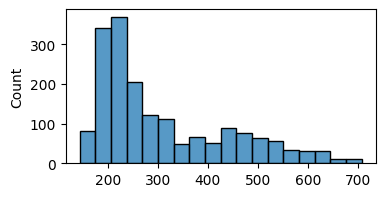

In [23]:
token_lengths = []
for prompt_list in data['prompt']:
    # Each prompt is a list of dictionaries, we want the 'content' of the first dict
    # Tokenize the content
    tokens = tokenizer.apply_chat_template(prompt_list)
    token_lengths.append(len(tokens))

token_lengths = np.array(token_lengths)
_, ax = plt.subplots(1, 1, figsize=(4, 2))
sns.histplot(token_lengths)

In [24]:
df_train_ = dfm.iloc[np.arange(len(token_lengths))[token_lengths<512]]
df_train_.index = range(len(df_train_))

In [25]:
data_train = Dataset.from_pandas(df_train_)

In [26]:
data_train

Dataset({
    features: ['question', 'answer', 'story_group', 'story', 'prompt'],
    num_rows: 1622
})

In [27]:
data_train.to_parquet('../data/train/ToM_train_single_question.parquet')

Creating parquet from Arrow format: 100%|██████████| 2/2 [00:00<00:00, 332.33ba/s]


3893166

In [69]:
1622/8

202.75

In [24]:
import re

In [25]:
def extract_xml_answer(text: str) -> str:
    answer_pattern = r'<answer>(.*?)</answer>'
    matches = list(re.finditer(answer_pattern, text, re.DOTALL))
    if not matches:
        return None
        
    final_answer = matches[-1].group(1).strip()
    return final_answer



def normalize_answer(answer: str) -> str:
    """Normalizes the answer text for better comparison.
    Args:
        answer: Raw answer text
    Returns:
        Normalized answer text
    """
    # Convert to lowercase
    normalized = answer.lower()
    # Remove extra whitespace
    normalized = re.sub(r'\s+', ' ', normalized).strip()
    # Remove punctuation that doesn't affect meaning
    normalized = re.sub(r'[.,;:!?]', '', normalized)
    return normalized




def reward_func_(response, answer):
    pattern = r"^<think>.*?</think>\s*<answer>.*?</answer>$"
    match = re.match(pattern, response, re.DOTALL | re.MULTILINE)
    
    if match:
        response_ = extract_xml_answer(response)
        norm_response = normalize_answer(response_)
        norm_answer = normalize_answer(answer)
        ans_pattern = r"\b(?:in|at|on|inside)?\s*(?:the\s*)?" + re.escape(norm_answer) + r"\b$"
        match = re.match(ans_pattern, norm_response, re.DOTALL | re.MULTILINE)
        if match:
            return 2
        else:
            return 0.5
    else:
        return 0


In [26]:
answer = "<think>think</think><answer>airport terminal gate</answer>"
answer_wrong = "<think>think</think><answer>(2) at the  . 'airport gate'\n </answer>"
answer_p1 = "<think>think</think><answer>'airport terminal gate area.</answer>"
answer_p2 = "<think>think</think><answer>in airport terminal gate.</answer>"

In [27]:
reward_func_(answer, 'airport terminal gate')

2

In [28]:
reward_func_(answer_wrong, 'airport terminal gate')

0.5

In [29]:
reward_func_(answer_p1, 'airport terminal gate')

0.5

In [30]:
reward_func_(answer_p2, 'airport terminal gate')

2